# 0-π Qubit

In this notebook, we try to reproduce the result of the ["Coherence properties of the 0-π qubit"](https://iopscience-iop-org.stanford.idm.oclc.org/article/10.1088/1367-2630/aab7cd) paper.

## Introduction

Our goal is to reproduce the enegry spectrum and eigenfunctions that [Groszkowski2018](https://iopscience-iop-org.stanford.idm.oclc.org/article/10.1088/1367-2630/aab7cd) is calculated for the $0-\pi$ qubit. The diagram of the circuit is

<img src="pics/zeroPiQubit_pic1.png" width="220" align="left" />

We choose the parameter set 3 for the circuit from the following table of the paper:

<img src="pics/zeroPiQubit_pic2.png" width="400" align="left" />

## Circuit description

Firstly, we import the SQcircuit and the relavant libraries

In [1]:
import os 
os.chdir("..")
import SQcircuit as sq
import matplotlib.pyplot as plt
import numpy as np

We define the single inductive loop of the circuit via `Loop` class

In [2]:
loop1 = sq.Loop()

The elements of the circuit can be defined via `Capacitor`, `Inductor`, and `Junction` classes in SQcircuit, and to define the circuit, we use the `Circuit` class. 

In [3]:
# define the circuit ’s elements
C = sq.Capacitor(0.15, "GHz")
CJ = sq.Capacitor(10, "GHz")
JJ = sq.Junction(5, "GHz", loops=[loop1])
L = sq.Inductor(0.13, "GHz", loops=[loop1])

# define the circuit
elements = {(0, 1): [CJ, JJ],
            (0, 2): [L],
            (0, 3): [C],
            (1, 2): [C],
            (1, 3): [L],
            (2, 3): [CJ, JJ]}
zrPi = sq.Circuit(elements)

By creating an object of `Circuit` class, SQcircuit systematically finds the correct set of transformations and basis to make the circuit ready to be diagonalized. However, before setting the truncation numbers for each mode and diagonalizing the Hamiltonian, we can gain more insight into our circuit by calling the `description()` method. This prints out which mode in SQcircuit is the charge mode or the harmonic mode with its natural frequency in GHz( the default unit). Moreover, it shows the prefactors in the Josephson junction part of the Hamiltonian $\tilde{\textbf{w}}_k$, which helps find the modes decoupled from the nonlinearity of the circuit.

In [4]:
zrPi.description()

mode_1: 	harmonic	freq=3.2248877883788323
mode_2: 	harmonic	freq=0.39496850170368347
mode_3: 	charge
w1: 	[-1.  0.  1.]
w2: 	[-1.  0. -1.]


The above output shows that the first two modes of the `zrPi` circuit are harmonic modes with the natural frequency of 3.22 and 0.39 in the frequency unit of SQcircuit (which is GHz in default), and the third mode is a charge mode. From `w1` and `w2`, it becomes clear that the prefactor of the second mode is zero for both Josephson Junctions, which means that the second mode is decoupled from the other modes. We can remove it by setting its truncation number to one.

To determine the size of the Hilbert space, we specify the truncation number for each circuit mode via `truncationNumbers()` method. Note that this is a necessary step before diagonalizing the circuit.

In [5]:
zrPi.truncationNumbers([35, 1, 11])

## Circuit spectrum

To generate the spectrum of the circuit, firstly, we need to change and sweep the external flux of `loop1` by the `setFlux()` method. Then, we need to find the eigenfrequencies of the circuit that correspond to that external flux via `diag()` method. The following lines of code find the `spec` a 2D NumPy array so that each column of it contains the eigenfrequencies with respect to its external flux. 

In [6]:
# external flux for sweeping over
phi = np.linspace(0,1,100)

# spectrum of the circuit
numEig=5
spec = np.zeros((numEig, len(phi)))

for i in range(len(phi)):
    # set the external flux for the loop
    loop1.setFlux(phi[i])
    
    # diagonlize the circuit
    spec[:, i], _ = zrPi.diag(numEig)

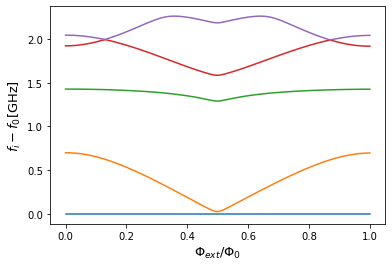

In [7]:
plt.figure()
for i in range(numEig):
    plt.plot(phi, spec[i,:]- spec[0,:])
    
plt.xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
plt.ylabel(r"$f_i-f_0$[GHz]", fontsize=13)
plt.show()

The next cell shows the spectrum from the figure 4 of the paper, which is the same spectrum that SQcircuit calculated.

<img src="pics/zeroPiQubit_pic3.png" width="250" align = "left" />

## Eigenfunctions

We can get the phase space eigenfunction of a specific eigenvector of a circuit by using the `eigPhaseSpace()` method. To calculate the eigenfunction at $\Phi_{ext} = 0.9\Phi_0$ similar to paper, we set back the flux of our loop to $0.9\Phi_0$ and diagonalize the `zrPi` again.

In [8]:
loop1.setFlux(0.9*2*np.pi)
zrPi.truncationNumbers([35, 1, 11])
_, _ = zrPi.diag(numEig)

We generate the eigenfunction in the phase space by `eigPhaseSpace()` method for the ground and first excited state.

In [9]:
# create a range for each mode
phi1=np.pi*np.linspace(-1,1,100)
phi2=0
phi3=np.pi*np.linspace(-0.5,1.5,100)

# the ground state
state0 = zrPi.eigPhaseCoordinate(eigInd = 0, grid = [phi1, phi2, phi3])
    
# the first excited state
state1 = zrPi.eigPhaseCoordinate(eigInd = 1, grid = [phi1, phi2, phi3])

Text(0, 0.5, '$\\theta$')

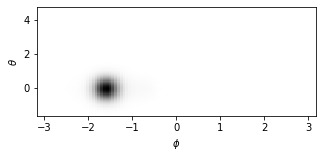

In [10]:
plt.figure(figsize=(5, 2))
plt.pcolor(phi1, phi3, np.abs(state0)**2,cmap="binary",shading='auto')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\theta$')

Text(0, 0.5, '$\\theta$')

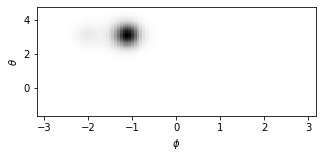

In [11]:
plt.figure(figsize=(5, 2))
plt.pcolor(phi1, phi3, np.abs(state1)**2,cmap="binary",shading='auto')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$\theta$')